Market: NEM VIC1
Goal: battery arbitrage
Model: quantile regression + conformal intervals
Policy: trade only when interval is tight
Compare vs baseline threshold

FULL end to end demonstration of how:
    - data is collected
    - data is cleaned
    - data is analysed 
And then:
    - use of the quantile regression modules
With the main focus on the arbitrage simulaiton


# End-to-end pipeline
This notebook runs the project end to end: data collection, cleaning, forecasting, and arbitrage backtesting.

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from Data_collection import collect_data, merge_monthly_files_sql
from Data_cleaning import load_data, split_and_clean_data, save_data
from arbitrage_sim import (
    baseline_threshold_policy,
    build_multi_horizon_conformal_forecasts,
    make_multi_horizon_precomputed_policy,
    make_battery_from_defaults,
    run_arbitrage_simulation,
    series_mwh_to_kwh,
    wrap_spike_discharge_policy,
 )
import backtest_plots
importlib.reload(backtest_plots)
from backtest_plots import (
    plot_battery_soc,
    plot_cumulative_profit,
    plot_cumulative_profit_overlay,
    plot_drawdown,
    plot_drawdown_overlay,
 )
from time_utils import infer_step_minutes

## 1) Data collection 
Download monthly AEMO price and demand CSVs, then merge into a single file. Set `RUN_DOWNLOAD` to True only when you want to fetch data. Since data that you already have can be skipped, only the first run will take some time downloading data


In [11]:
RUN_DOWNLOAD = False

raw_dir = "aemo_vic1"
merged_file = "PRICE_AND_DEMAND_FULL_VIC1.csv"

if RUN_DOWNLOAD or not os.path.exists(merged_file):
    collect_data(start_year=2023, end_year=2026, state="VIC1", out_dir=raw_dir)
    merge_monthly_files_sql(state="VIC1", in_dir=raw_dir, out_file=merged_file, db_file="aemo_merge.sqlite")

print("Merged file exists:", os.path.exists(merged_file))

Merged file exists: True


## 2) Clean data and build features
This step creates train/test sets and writes cleaned CSVs used by the modeling pipeline.

In [12]:
train_clean_path = "CLEANED_PRICE_AND_DEMAND_VIC1_TRAIN.csv"
test_clean_path = "CLEANED_PRICE_AND_DEMAND_VIC1_TEST.csv"

if not (os.path.exists(train_clean_path) and os.path.exists(test_clean_path)):
    df_full = load_data(merged_file)
    train_final, test_final = split_and_clean_data(df_full)
    save_data(train_final, test_final)

train_df = pd.read_csv(train_clean_path, parse_dates=["SETTLEMENTDATE"], index_col="SETTLEMENTDATE")
test_df = pd.read_csv(test_clean_path, parse_dates=["SETTLEMENTDATE"], index_col="SETTLEMENTDATE")

print("Train rows:", len(train_df), "Test rows:", len(test_df))

Train rows: 257951 Test rows: 64280


## 3) Train quantile models and build conformal forecasts
This step fits quantile models per horizon and builds rolling conformal intervals.

In [13]:
import importlib
import arbitrage_sim
importlib.reload(arbitrage_sim)
wrap_spike_discharge_policy = arbitrage_sim.wrap_spike_discharge_policy

In [14]:
horizons_minutes = [60, 120]
quantiles = [0.05, 0.5, 0.95]

conformal_dfs, q_by_horizon = build_multi_horizon_conformal_forecasts(
    horizons_minutes=horizons_minutes,
    quantiles=quantiles,
    quantile_low=0.05,
    quantile_high=0.95,
    target_coverage=0.90,
    rolling_window=500,
    min_warmup=200,
)

print("Built conformal forecasts for horizons:", list(conformal_dfs.keys()))

2026-02-15 14:30:38,358 - arbitrage_sim - INFO - Training quantile models for horizon 60 minutes...
2026-02-15 14:30:39,673 - root - INFO - NaNs in X_train: 0 (0.0000% of entries), NaNs in X_test: 0 (0.0000% of entries)
2026-02-15 14:31:09,557 - arbitrage_sim - INFO - Training quantile models for horizon 120 minutes...
2026-02-15 14:31:11,601 - root - INFO - NaNs in X_train: 0 (0.0000% of entries), NaNs in X_test: 0 (0.0000% of entries)
Built conformal forecasts for horizons: [60, 120]


## 4) Run arbitrage simulation
Build the decision-time price series and simulate the battery trading policy.

In [ ]:

import importlib
import arbitrage_sim
importlib.reload(arbitrage_sim)

price_series_mwh = test_df["RRP"].copy()
price_series_kwh = series_mwh_to_kwh(price_series_mwh)
price_series_kwh = price_series_kwh.sort_index()

step_minutes = infer_step_minutes(price_series_kwh.index, fallback_minutes=5.0)
dt_hours = step_minutes / 60.0
print("step_minutes:", step_minutes, "dt_hours:", dt_hours)

selected_horizons = [60, 120]

policy_callable, policy_params = arbitrage_sim.make_multi_horizon_aggressive_policy(
    conformal_dfs,
    horizons_minutes=selected_horizons,
    fee_rate=0.01,
    cost_per_kwh=0.0,
    min_signal_charge_aud_per_kwh=0.0,
    min_signal_discharge_aud_per_kwh=0.0,
    power_kw=None,       # None => battery.max_power_kw
    soc_buffer=0.05,
    horizon_discount_minutes=90.0,
    edge_k=0.1, # so far best edge_k I've tested is 0.05 for decent per cycle profit. But 0.01 has higher trading frequency with lower per cycle profit
    edge_buffer_aud_per_kwh=0.01,
    min_margin_aud_per_kwh=0.02,
    min_power_frac=0.1, # so far best min_power_frac I've tested is 0.05
    min_hold_steps=2,
    min_switch_delta_aud_per_kwh=0.01,
    collect_diagnostics=True,
 )

policy_callable, spike_params = wrap_spike_discharge_policy(
    policy_callable,
    training_prices_kwh=series_mwh_to_kwh(train_df["RRP"].copy()),
    spike_price_quantile=0.99,
    spike_discharge_power=None,
    soc_buffer=0.05,
 )

battery = make_battery_from_defaults()
actions_df, metrics = run_arbitrage_simulation(
    prices=price_series_kwh,
    battery=battery,
    dt_hours=dt_hours,
    policy=policy_callable,
    fee_rate=0.01,
    degradation_cost_per_kwh=0.0001,
 )

print(metrics)

step_minutes: 5.0 dt_hours: 0.08333333333333333
SimulationMetrics(total_profit=np.float64(654.1988656383719), terminal_value=np.float64(4.809614420780612), total_profit_with_terminal=np.float64(659.0084800591525), max_drawdown=138.7234682688923, max_equity_drawdown=238.6716363906823, grid_throughput_kwh=np.float64(35833.041202355074), equivalent_cycles=np.float64(179.16520601177538), profit_per_cycle=np.float64(3.651372273673358), profit_drawdown_ratio=np.float64(2.7409996241342722))


In [105]:
train_price_series_kwh = series_mwh_to_kwh(train_df["RRP"].copy())

baseline_policy_callable, baseline_params = baseline_threshold_policy(
    training_prices_kwh=train_price_series_kwh,
    low_quantile=0.3,
    high_quantile=0.7,
 )

baseline_battery = make_battery_from_defaults()
baseline_actions_df, baseline_metrics = run_arbitrage_simulation(
    prices=price_series_kwh,
    battery=baseline_battery,
    dt_hours=dt_hours,
    policy=baseline_policy_callable,
    fee_rate=0.01,
    degradation_cost_per_kwh=0.0001,
 )

comparison_df = pd.DataFrame(
    [
        {
            "policy": "baseline_threshold",
            "total_profit_with_terminal": baseline_metrics.total_profit_with_terminal,
            "max_equity_drawdown": baseline_metrics.max_equity_drawdown,
            "profit_per_cycle": baseline_metrics.profit_per_cycle,
        },
        {
            "policy": "conformal_multi_horizon",
            "total_profit_with_terminal": metrics.total_profit_with_terminal,
            "max_equity_drawdown": metrics.max_equity_drawdown,
            "profit_per_cycle": metrics.profit_per_cycle,
        },
    ]
 )

print(comparison_df)

                    policy  total_profit_with_terminal  max_equity_drawdown  \
0       baseline_threshold                 1639.882232            89.079788   
1  conformal_multi_horizon                  659.008480           238.671636   

   profit_per_cycle  
0         12.841291  
1          3.651372  


## 5) Inspect results
Plot profit, equity, and state of charge over time.

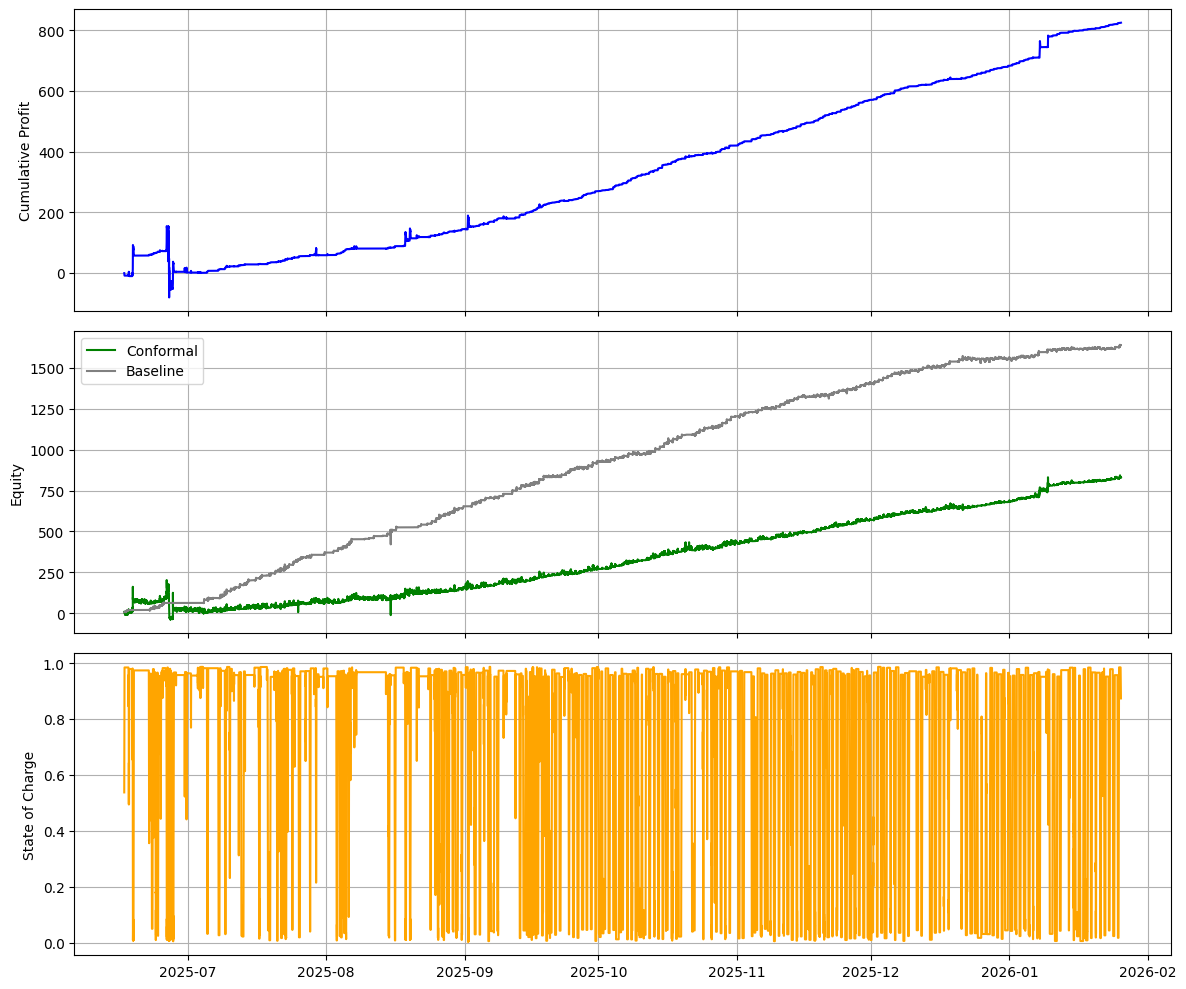

In [91]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(actions_df.index, actions_df["cumulative_profit"], color="blue")
axes[0].set_ylabel("Cumulative Profit")
axes[0].grid(True)

axes[1].plot(actions_df.index, actions_df["equity"], label="Conformal", color="green")
axes[1].plot(baseline_actions_df.index, baseline_actions_df["equity"], label="Baseline", color="gray")
axes[1].set_ylabel("Equity")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(actions_df.index, actions_df["new_soc"], color="orange")
axes[2].set_ylabel("State of Charge")
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 6) Backtest plots (helper utilities)
Convert the simulation output to the format expected by backtest_plots and render its plots.

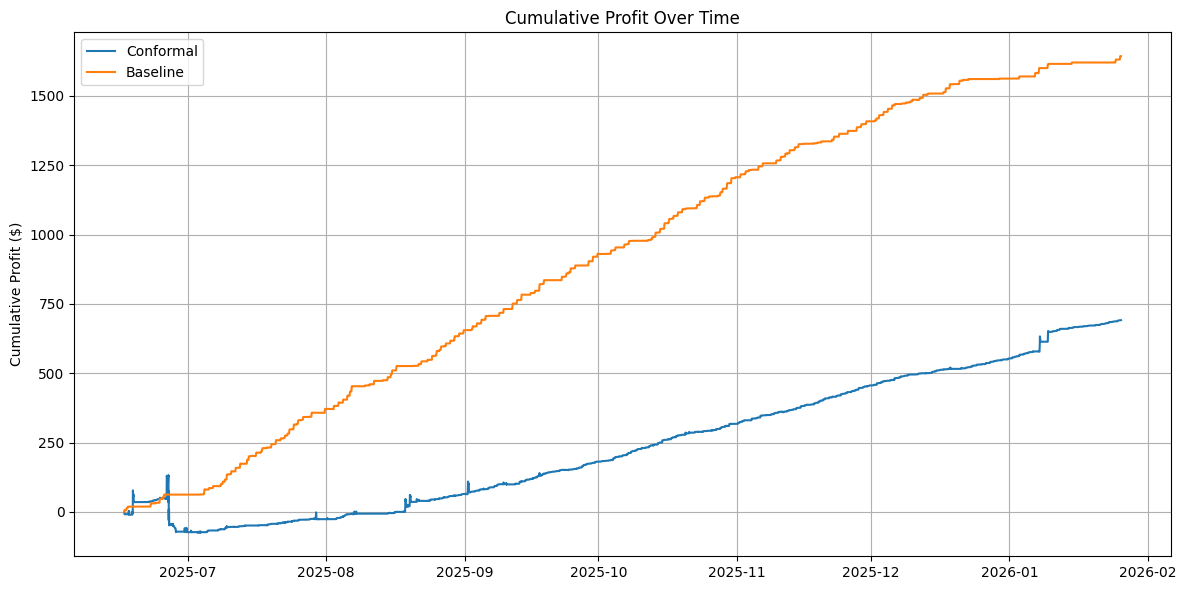

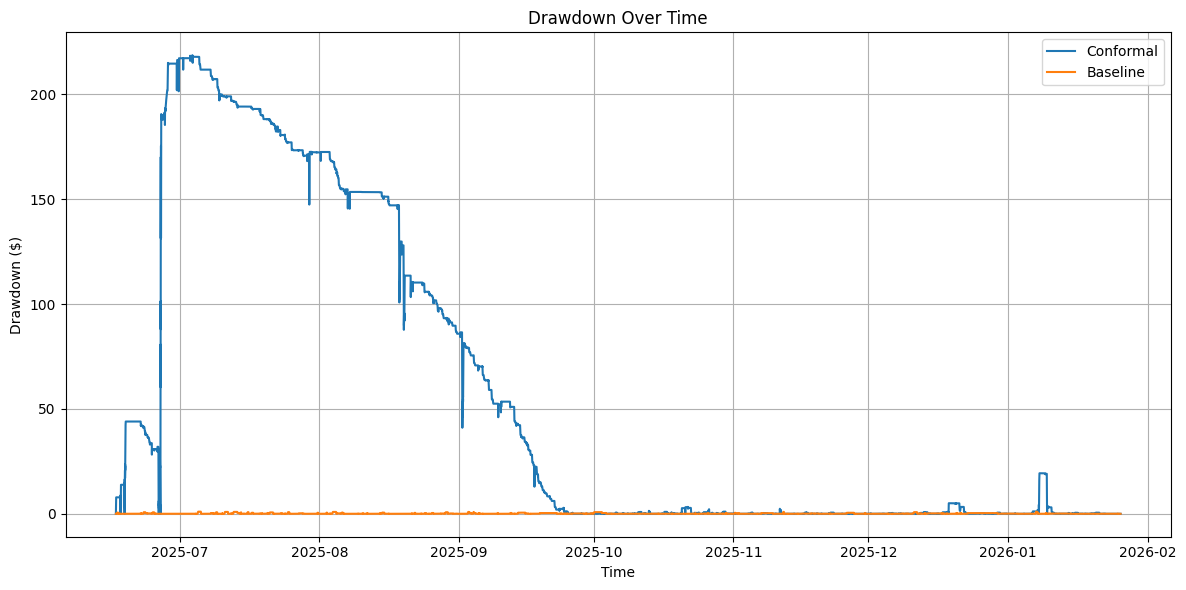

In [79]:
plot_df = actions_df.reset_index().rename(columns={"index": "timestamp"})
baseline_plot_df = baseline_actions_df.reset_index().rename(columns={"index": "timestamp"})

if "timestamp" not in plot_df.columns:
    plot_df = plot_df.rename(columns={plot_df.columns[0]: "timestamp"})
if "timestamp" not in baseline_plot_df.columns:
    baseline_plot_df = baseline_plot_df.rename(columns={baseline_plot_df.columns[0]: "timestamp"})

plot_df["action_kwh"] = plot_df["energy_sold_kwh"] - plot_df["energy_bought_kwh"]
plot_df["soc_kwh"] = plot_df["new_soc"] * battery.capacity_kwh

baseline_plot_df["action_kwh"] = baseline_plot_df["energy_sold_kwh"] - baseline_plot_df["energy_bought_kwh"]
baseline_plot_df["soc_kwh"] = baseline_plot_df["new_soc"] * baseline_battery.capacity_kwh

plot_cumulative_profit_overlay(
    [plot_df.copy(), baseline_plot_df.copy()],
    ["Conformal", "Baseline"],
    fee_rate=0.01,
 )
plot_drawdown_overlay([plot_df.copy(), baseline_plot_df.copy()], ["Conformal", "Baseline"])

## 7) Results table
Summarize the key metrics for each policy in one place.

In [92]:
results_df = pd.DataFrame(
    [
        {
            "policy": "baseline_threshold",
            "total_profit_with_terminal": baseline_metrics.total_profit_with_terminal,
            "max_equity_drawdown": baseline_metrics.max_equity_drawdown,
            "equivalent_cycles": baseline_metrics.equivalent_cycles,
            "profit_per_cycle": baseline_metrics.profit_per_cycle,
        },
        {
            "policy": "conformal_multi_horizon",
            "total_profit_with_terminal": metrics.total_profit_with_terminal,
            "max_equity_drawdown": metrics.max_equity_drawdown,
            "equivalent_cycles": metrics.equivalent_cycles,
            "profit_per_cycle": metrics.profit_per_cycle,
        },
    ]
 )

results_df

,policy,total_profit_with_terminal,max_equity_drawdown,equivalent_cycles,profit_per_cycle
0,baseline_threshold,1639.882232,89.079788,127.703840,12.841291
1,conformal_multi_horizon,829.915860,241.303654,225.182537,3.663825


## 8) Diagnostics (why baseline might win)
Compare throughput and profit efficiency side-by-side.

In [106]:
diagnostics_df = pd.DataFrame(
    [
        {
            "policy": "baseline_threshold",
            "grid_throughput_kwh": baseline_metrics.grid_throughput_kwh,
            "equivalent_cycles": baseline_metrics.equivalent_cycles,
            "avg_profit_per_kwh": baseline_metrics.total_profit / baseline_metrics.grid_throughput_kwh if baseline_metrics.grid_throughput_kwh > 0 else float("nan"),
        },
        {
            "policy": "conformal_multi_horizon",
            "grid_throughput_kwh": metrics.grid_throughput_kwh,
            "equivalent_cycles": metrics.equivalent_cycles,
            "avg_profit_per_kwh": metrics.total_profit / metrics.grid_throughput_kwh if metrics.grid_throughput_kwh > 0 else float("nan"),
        },
    ]
 )

diagnostics_df

,policy,grid_throughput_kwh,equivalent_cycles,avg_profit_per_kwh
0,baseline_threshold,25540.768004,127.703840,0.064206
1,conformal_multi_horizon,35833.041202,179.165206,0.018257


## 9) What does this all mean?

### Key Findings

#### 1. Threshold policies remain extremely strong baselines

The baseline policy, which charges when prices are historically low and discharges when prices are high (using the 30th and 70th quantiles), consistently achieved higher profit and lower drawdown than the conformal forecast-based policy. This demonstrates how simple models can be highly effective, particularly in electricity arbitrage markets where extreme price spikes dominate overall profitability.

#### 2. Forecast-based policies introduce a trade-off between selectivity and profitability

The conformal multi-horizon policy traded less frequently when configured conservatively, resulting in lower total profit but reduced exposure to uncertain market conditions. When the decision thresholds were relaxed, total profit increased significantly, but at the cost of much lower average profit per kWh traded. This highlights the trade-off between trading efficiency and overall profit which should be configured based on your own goals.

#### 3. Forecast uncertainty alone is not sufficient to guarantee superior trading performance

Although conformal prediction provides well-calibrated uncertainty intervals, using interval width as a strict decision filter can lead to overly conservative behavior. The results suggest that while uncertainty estimation is valuable, actually translating this to making profitable trades is quite difficult due to the spikey nature of the electricity market 

---

### Overall Conclusion

This project demonstrates that conformal prediction can be successfully integrated into a battery arbitrage decision framework, providing calibrated uncertainty estimates and uncertainty aware trading strategies.

However, in this setting, a simple threshold-based policy achieved higher raw profitability due to its ability to aggressively capture extreme price events. While the conformal stategy failed to do so and moreso even suffered from worse drawdowns and profit per kwh traded. The conformal framework remains valuable as was seen when testing directional accuracy achieving impressive % of up to 68% as can be seen in `Quantile_regrsesion.py` however it does not appear to perform well as a solo strategy. An improvement may lie in combining the two strategies later on to use both historical data and predictive measures to try best the simple threshold policy.

Overall, this project highlights the importance of evaluating advanced forecasting methods against strong baselines and understanding tradeoffs while also recognising that simple models can indeed outperform much more advanced ones. 
